<a href="https://colab.research.google.com/github/gongx030/etv2_pioneer/blob/master/TFBS_in_commonly_regulated_genes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Find the enriched TFBS (motifs) in commonly up- and down-regulated genes in EB and MEFs on Etv2 induction.
by Wuming Gong



In [1]:
start_time0 <- Sys.time()

## Install R packages

In [2]:
system('apt-get -q install libgsl-dev', intern = TRUE)

[1] "Reading package lists..."                                       
[2] "Building dependency tree..."                                    
[3] "Reading state information..."                                   
[4] "libgsl-dev is already the newest version (2.4+dfsg-6)."         
[5] "0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded."

In [3]:
system('apt-get install libcairo2-dev', intern = TRUE) # for Cairo package that is required by ComplexHeatmap package

[1] "Reading package lists..."                                         
[2] "Building dependency tree..."                                      
[3] "Reading state information..."                                     
[4] "libcairo2-dev is already the newest version (1.15.10-2ubuntu0.1)."
[5] "0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded."

In [4]:
install.packages('BiocManager')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [5]:
required_packages <- c(
  'devtools', 'circlize', 'dplyr', 'gplots', 'plyr',
  'SummarizedExperiment', 'BSgenome.Mmusculus.UCSC.mm10', 'BiocParallel', 
  'rtracklayer', 'EnrichedHeatmap', 'ChIPpeakAnno', 'ChIPseeker', 'TxDb.Mmusculus.UCSC.mm10.knownGene', 
  'gsl', 'DirichletMultinomial', 'chromVAR', 'motifmatchr', 'PWMEnrich',
  'ComplexHeatmap',
  'DESeq2',
  'VennDiagram', 'ggwordcloud',
  'biomaRt'
)

In [6]:
missing_packages <- required_packages[!required_packages %in% rownames(installed.packages())]
if (length(missing_packages) > 0){
    BiocManager::install(missing_packages)
}

In [7]:
devtools::install_github("GreenleafLab/chromVARmotifs")

Skipping install of 'chromVARmotifs' from a github remote, the SHA1 (38bed559) has not changed since last install.
  Use `force = TRUE` to force installation



In [35]:
library(chromVARmotifs)
library(chromVAR)
library(BSgenome.Mmusculus.UCSC.mm10)
library(motifmatchr)
library(BiocParallel)
library(SummarizedExperiment)
library(gplots)
library(circlize)
library(ComplexHeatmap)
register(MulticoreParam(2)) 
library(plyr)
library(dplyr)
library(DESeq2)
library(VennDiagram)
library(ggwordcloud)
library(biomaRt)
library(GenomicFeatures)
library(Matrix)


Attaching package: ‘Matrix’


The following object is masked from ‘package:S4Vectors’:

    expand




## Read scRNA-seq of MEF reprogramming

In [9]:
sc_file <- 'https://s3.msi.umn.edu/gongx030/etv2_pioneer/data/processed_Etv2_scRNAseq.rds'
command <- sprintf('wget -x -c -nH %s', sc_file)
command %>% system()

In [10]:
se_sc <- gsub('https://s3.msi.umn.edu/', './', sc_file) %>% readRDS()
table(colData(se_sc)$group)


  MEF_NoDox  MEF_Dox_D1  MEF_Dox_D2 MEF_Dox_D7a MEF_Dox_D7b 
       3562         948        2936        7202         827 

## Find the DE genes between MEF D7 Flk1+ cells and undifferentiated MEF

In [11]:
X <- assays(se_sc)$scaled_counts
j_MEF_NoDox <- colData(se_sc)$group %in% 'MEF_NoDox'
j_MEF_Dox_D7_Flk1pos <- colData(se_sc)$group %in% c('MEF_Dox_D7b')
pvalues <- mclapply(
  1:nrow(X), 
  function(i) wilcox.test(X[i, j_MEF_Dox_D7_Flk1pos], X[i, j_MEF_NoDox])$p.value,
  mc.cores = 2
) %>% unlist()

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)



## Read bulk RNA-seq of EB differentiation

In [12]:
se_bulk <- readRDS(gzcon(url('https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2RNA-seq_version=20190909a/se.rds')))

## Find  DE genes between no dox and Flk1+ cells post induction

In [13]:
se_bulk <- DESeqDataSet(se_bulk, design = ~ group)
se_bulk <- estimateSizeFactors(se_bulk)
se_bulk <- DESeq(se_bulk)
assays(se_bulk)$normalized_counts <- log2(counts(se_bulk, normalized = TRUE) + 1)
res <- results(se_bulk, contrast = c('group', 'EB_Dox_D25_Flk1pos_Etv2', 'EB_NoDox_D25_Etv2'))

Warning message in DESeqDataSet(se_bulk, design = ~group):
“some variables in design formula are characters, converting to factors”
using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



## Merge the scRNA-seq and bulk RNA-seq by gene symbols.


In [14]:
d_rna_merge <- merge(
  data.frame(
    symbol = rownames(res), 
    EB_log2FoldChange = res$log2FoldChange, 
    EB_pvalue = res$pvalue
  ),
  data.frame(
    symbol = rowData(se_sc)$name, 
    MEF_log2FoldChange = rowMeans(X[, j_MEF_Dox_D7_Flk1pos]) - rowMeans(X[, j_MEF_NoDox]), 
    MEF_pvalue = pvalues
  ),
  by.x = 'symbol',
  by.y = 'symbol'
) %>%
  filter(!is.na(EB_pvalue) & !is.na(MEF_pvalue)) %>%
  filter(!duplicated(symbol))
rownames(d_rna_merge) <- d_rna_merge$symbol
d_rna_merge %>% filter(symbol %in% c('Etv2', 'Kdr', 'Emcn', 'Cdh5', 'Runx1'))

,symbol,EB_log2FoldChange,EB_pvalue,MEF_log2FoldChange,MEF_pvalue
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Cdh5,Cdh5,7.534863,1.315189e-43,1.5647330,0.000000e+00
Emcn,Emcn,5.908320,6.634402e-03,1.4578199,0.000000e+00
Etv2,Etv2,5.462880,0.000000e+00,1.1166636,3.666651e-272
Kdr,Kdr,7.093824,0.000000e+00,1.7277936,0.000000e+00
Runx1,Runx1,1.891086,1.139845e-11,-0.3865211,1.138801e-25


## Summarize commonly up- and down-regulated genes

In [15]:
up_in_EB <- d_rna_merge$EB_pvalue < 1e-3 & d_rna_merge$EB_log2FoldChange > 0
up_in_MEF <- d_rna_merge$MEF_pvalue < 1e-3 & d_rna_merge$MEF_log2FoldChange > 0
down_in_EB <- d_rna_merge$EB_pvalue < 1e-3 & d_rna_merge$EB_log2FoldChange < 0
down_in_MEF <- d_rna_merge$MEF_pvalue < 1e-3 & d_rna_merge$MEF_log2FoldChange < 0
sprintf('# of up-regulated genes in EB: %d', sum(up_in_EB)) %>% message()
sprintf('# of up-regulated genes in MEF: %d', sum(up_in_MEF)) %>% message()
sprintf('# of up-regulated genes in both EB and MEF: %d', sum(up_in_EB & up_in_MEF)) %>% message()
sprintf('# of down-regulated genes in EB: %d', sum(down_in_EB)) %>% message()
sprintf('# of down-regulated genes in MEF: %d', sum(down_in_MEF)) %>% message()
sprintf('# of down-regulated genes in both EB and MEF: %d', sum(down_in_EB & down_in_MEF)) %>% message()

# of up-regulated genes in EB: 2308

# of up-regulated genes in MEF: 2057

# of up-regulated genes in both EB and MEF: 615

# of down-regulated genes in EB: 2319

# of down-regulated genes in MEF: 5421

# of down-regulated genes in both EB and MEF: 1395



## Retrieve the TSS regions of all genes

In [16]:
mouse <- useMart("ensembl", dataset = "mmusculus_gene_ensembl") # mm10

Ensembl site unresponsive, trying useast mirror

Ensembl site unresponsive, trying asia mirror



In [17]:
bm <- getBM(
  attributes = c('external_gene_name', 'ensembl_transcript_id', 'chromosome_name', 'transcription_start_site', 'strand'),
  filters = 'external_gene_name',
  values = d_rna_merge$symbol,
  mart = mouse
)

In [18]:
bm <- bm %>% 
  filter(chromosome_name %in% c(1:19, 'X', 'Y')) %>%
  mutate(strand = if_else(strand == 1, '+', '-')) %>%
  mutate(seqnames = sprintf('chr%s', chromosome_name)) 

In [19]:
d_rna_merge$symbol[up_in_EB] %>% head()

[1] "1110059E24Rik" "1500009L16Rik" "1600012H06Rik" "1600020E01Rik"
[5] "1700020I14Rik" "1700029J07Rik"

In [20]:
gr <- GRanges(
  seqnames = bm$seqnames,
  range = IRanges(start = bm$transcription_start_site, width = 1L),
  strand = bm$strand,
  external_gene_name = bm$external_gene_name,
  ensembl_transcript_id = bm$ensembl_transcript_id,
  up_in_EB = bm$external_gene_name %in% d_rna_merge$symbol[up_in_EB],
  up_in_MEF = bm$external_gene_name %in% d_rna_merge$symbol[up_in_MEF],
  down_in_EB = bm$external_gene_name %in% d_rna_merge$symbol[down_in_EB],
  down_in_MEF = bm$external_gene_name %in% d_rna_merge$symbol[down_in_MEF],
  up_in_both = bm$external_gene_name %in% d_rna_merge$symbol[up_in_EB] & bm$external_gene_name %in% d_rna_merge$symbol[up_in_MEF],
  down_in_both = bm$external_gene_name %in% d_rna_merge$symbol[down_in_EB] & bm$external_gene_name %in% d_rna_merge$symbol[down_in_MEF]
)

The upstream/downstream 10K region of each TSS

In [21]:
gr <- gr %>% resize(fix = 'center', width = 5000)

In [47]:
GT <- sparseMatrix(
  i = as.numeric(factor(gr$external_gene_name, rownames(d_rna_merge))),
  j = 1:length(gr),
  dims = c(nrow(d_rna_merge), length(gr)),
  dimnames = list(rownames(d_rna_merge), NULL)
) # gene ~ transcripts (TSS)

## Find the motifs that are present in each extended TSS region

In [22]:
data("homer_pwms") 
motif_ix <- matchMotifs(homer_pwms, gr, genome = 'mm10', out = 'positions')

In [26]:
ids <- rep(1:length(motif_ix), sapply(motif_ix, length))

In [27]:
motif_ix <- unlist(motif_ix)

In [42]:
MB <- sparseMatrix(
  i = ids,
  j = 1:length(motif_ix),
  dims = c(length(homer_pwms), length(motif_ix)),
  dimnames = list(names(homer_pwms), NULL)
) %>% 
  as('dgCMatrix') # motif ~ TFBS

In [29]:
mm <- findOverlaps(motif_ix, gr) %>% as.matrix()

In [39]:
BT <- sparseMatrix(
  i = mm[, 1],
  j = mm[, 2],
  dims = c(length(motif_ix), length(gr))
) # TFBS ~ TSS

In [43]:
MT <- MB %*% BT # motif ~ TSS, occurence

In [54]:
GM <- Diagonal(x = 1 / rowSums(GT)) %*% GT %*% t(MT)

In [94]:
pvalue_up_EB <- sapply(1:ncol(GM), function(i) wilcox.test(GM[up_in_EB , i],GM[!up_in_EB, i], alternative = 'greater')$p.value)
pvalue_up_MEF <- sapply(1:ncol(GM), function(i) wilcox.test(GM[up_in_MEF, i],GM[!up_in_MEF, i], alternative = 'greater')$p.value)
pvalue_down_MEF <- sapply(1:ncol(GM), function(i) wilcox.test(GM[down_in_MEF, i],GM[!down_in_MEF, i], alternative = 'greater')$p.value)
pvalue_down_EB <- sapply(1:ncol(GM), function(i) wilcox.test(GM[down_in_EB, i],GM[!down_in_EB, i], alternative = 'greater')$p.value)

In [137]:
df <- data.frame(
  name = colnames(GM),
  up_EB = pvalue_up_EB,
  down_EB = pvalue_down_EB,
  up_MEF = pvalue_up_MEF,
  down_MEF = pvalue_down_MEF
)

In [167]:
df <- df %>%
  filter((up_EB < 0.001 & up_MEF < 0.001) | (down_EB < 0.001 & down_MEF < 0.001))

In [168]:
xx <- df[, c('up_EB', 'up_MEF', 'down_EB', 'down_MEF')] %>% 
  as.matrix()
rownames(xx) <- gsub('\\(.+.+', '', df$name)

In [169]:
column_annotation <- HeatmapAnnotation(
  direction = c('up', 'up', 'down', 'down'),
  cell_type = c('EB', 'MEF', 'EB', 'MEF'),
  col = list(
    cell_type = c(
      'EB' = 'yellow',
      'MEF' = 'lightpink'
    ),
    direction = c(
      'up' = 'red',
      'down' = 'blue'
    )
  ),
  show_legend = TRUE,
  annotation_name_side = "left"
)

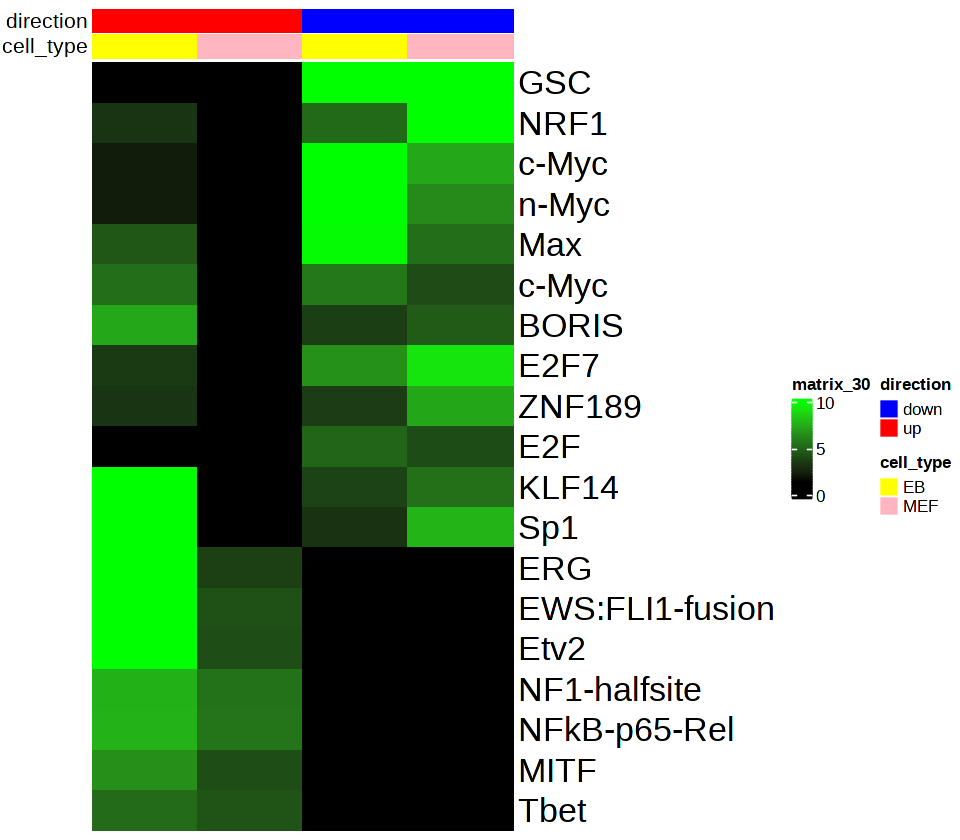

In [172]:
options(repr.plot.width = 8, repr.plot.height = 7)
col_fun <- colorRamp2(c(0, -log10(0.05), -log10(1e-10)), c("black", "black", "green"))
Heatmap(
  -log10(xx),
  cluster_rows = TRUE,
  cluster_columns = FALSE,
  show_column_dend = FALSE,
  show_row_dend = FALSE,
  show_column_names = FALSE,
  show_row_names = TRUE,
  col = col_fun,
  row_names_gp = gpar(fontsize = 20),
  top_annotation = column_annotation,
)

In [166]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      stats4    parallel  stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] Matrix_1.3-2                       GenomicFeatures_1.42.1            
 [3] AnnotationDbi_1.52.0               biomaRt_2.46.1                    
 [5] ggwordcloud_0.5.0                  ggplot2_3.3.3                     
 [7] Venn